In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
#from fase.core import heaan

from fase import HEAAN
from fase import HEAAN as he
from typing import List, Callable

from fase import hnrf as hnrf

from fase.hnrf.tree import NeuralTreeMaker
from fase.hnrf import heaan_nrf
from fase.hnrf.hetree import HomomorphicModel

from time import time

In [4]:
model_dir = "/home/hoseung/Work/Kinect_BBS_demo/nbs/"

CAM_LIST= {1: "e",
           2: "e",
           3: "a",
           4: "e",
           5: "e",
           6: "e",
           7: "e",
           8: "a",
           9: "a",
           10:"e",
           11:"e",
           12:"e",
           13:"a",
           14:"e"}
#for action in np.arange(1,15): 
# 3, 9는 아직 없음 , 12번 다시. 
action = 1
cam = CAM_LIST[action]


fn_model_out = f"trained_model_{action}_{cam}.pickle"
fn_data_out = f"BBS_dataset_{action}_{cam}.pickle"

fn_model = model_dir + fn_model_out
fn_dat = model_dir + fn_data_out

rf_model = pickle.load(open(fn_model, "rb"))

print("model's depth:", rf_model.max_depth)
print("model's tree count:", rf_model.n_estimators)


#####
dataset = pickle.load(open(fn_dat, "rb"))

X_train = dataset["train_x"]
y_train = dataset["train_y"]
X_valid = dataset["valid_x"]
y_valid = dataset["valid_y"]

print("min max of input dataset")
print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())

#####
from sklearn.tree import BaseDecisionTree
from fase.hnrf.tree import NeuralRF

dilatation_factor = 10
polynomial_degree = 10

estimators = rf_model.estimators_

my_tm_tanh = NeuralTreeMaker(torch.tanh,
                            use_polynomial=True,
                            dilatation_factor=dilatation_factor,
                            polynomial_degree=polynomial_degree)


model's depth: 7
model's tree count: 20
min max of input dataset
0.0 1.0000000000000002
0.0 1.0000000000000002


성능 확실함 

In [5]:
from fase.hnrf.hetree import HNRF
action = 1
cam = CAM_LIST[action]
Nmodel = pickle.load(open(f"Nmodel_{action}_{cam}.pickle", "rb"))

fn_model_out = f"trained_model_{action}_{cam}.pickle"
fn_data_out = f"BBS_dataset_{action}_{cam}.pickle"
fn_dat = model_dir + fn_data_out
fn_model = model_dir + fn_model_out

rf_model = pickle.load(open(fn_model, "rb"))

#####
dataset = pickle.load(open(fn_dat, "rb"))

X_train = dataset["train_x"]
y_train = dataset["train_y"]
X_valid = dataset["valid_x"]
y_valid = dataset["valid_y"]


pred = rf_model.predict(X_valid)

with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_valid).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")


h_rf = HNRF(Nmodel)

Original accuracy : 0.9149659863945578
Accuracy : 0.9421768707482994
Same output : 0.9136054421768708


In [7]:
logq = 540
logp = 30
logn = 14
n = 1*2**logn
slots = n


do_reduction=False

from fase.core.common import HEAANContext

logq = 540
logp = 30
logn = 14
hec = HEAANContext(logn, logp, logq, rot_l=[1],
                   key_path="/home/hoseung/Work/Kinect_BBS_demo/serkey/",
                   FN_SK="secret.key",
                   boot=False,
                   is_owner=True,
                   load_sk=True
                  )

cc = hec.encrypt([1,2,3,4])
dd = hec.lrot(cc, 1)
hec.decrypt(dd)

loading secret key done.
HEAAN CKKS setup is ready 


array([ 2.00000019e+00,  3.00000125e+00,  4.00000080e+00, ...,
        3.49577530e-07, -1.83688058e-06,  1.00000497e+00])

In [8]:
#server_path = "/home/hoseung/Work/Kinect_BBS_demo/server/"
t0 = time()

my_tm_tanh = NeuralTreeMaker(torch.tanh,
             use_polynomial=True,
             dilatation_factor=10,
             polynomial_degree=10)

nrf_evaluator = heaan_nrf.HETreeEvaluator(h_rf,
                                          hec._scheme,
                                          hec.parms,
                                          my_tm_tanh.coeffs,
                                          do_reduction = False,
                                          sk=hec.sk
                                          )
print(f"[EVAL.model_loader] HNRF model loaded for class {action} in {time() - t0:.2f} seconds")


featurizer = heaan_nrf.HETreeFeaturizer(h_rf.return_comparator(), hec._scheme, hec.parms)

for xx, yy in zip(X_valid[:9], y_valid[:9]):
    t0 = time()
    #print(len(xx))
    ctx = featurizer.encrypt(xx)
    result = nrf_evaluator(ctx)
    #print(f"Took {time() - t0:.2f} seconds")

    pred = []
    for res in result:
        dec = hec.decrypt(res)
        pred.append(np.sum(dec))

    print(f"Prediction: {np.argmax(pred)} == {yy}?")
    neural_pred = Nmodel(torch.tensor(xx.reshape(1,-1)).float())
    print(pred)
    print(neural_pred)
    print(f"{time() - t0} seconds")

CKKS paramters:
---------------------------
n = 16384
logp = 30
logq = 540
tanh activation polynomial coeffs = [-1.16068771e-16  4.75814899e+00  3.30039026e-15 -1.83821464e+01
 -2.46267653e-14  3.86047910e+01  6.66941250e-14 -3.72804331e+01
 -7.36380653e-14  1.33120796e+01  2.84217094e-14]
tanh activation polynomial degree = 10

Neural RF
---------------------------

[EVAL.model_loader] HNRF model loaded for class 1 in 10.88 seconds
Prediction: 3 == 3?
[-0.5832366943359376, -0.8536071777343749, 0.30851745605468744, 1.4260406494140627, 1.2083587646484377]
tensor([[-0.5825, -0.8535,  0.3087,  1.4260,  1.2085]], grad_fn=<AddBackward0>)
244.58722138404846 seconds
Prediction: 4 == 4?
[-0.575836181640625, -0.41778564453124983, -1.146728515625, 1.0041961669921875, 3.158004760742188]
tensor([[-0.5754, -0.4176, -1.1464,  1.0041,  3.1581]], grad_fn=<AddBackward0>)
246.3609013557434 seconds
Prediction: 2 == 2?
[1.1198425292968752, -0.3457336425781249, 3.0722045898437496, 0.5701141357421875, -3.42

KeyboardInterrupt: 

## Live skeleton

In [30]:
ctx_live = he.Ciphertext(hec.parms.logp, hec.parms.logq, hec.parms.n)
he.SerializationUtils.readCiphertext(ctxt, "/home/hoseung/Work/Kinect_BBS_demo/ctx_01_e_.dat")

ddl = hec.decrypt(ctx_live)

result = nrf_evaluator(ctx_live)
pred = []
for res in result:
    dec = hec.decrypt(res)
    pred.append(np.sum(dec))

print(f"Prediction: {np.argmax(pred)} == {yy}?")
neural_pred = Nmodel(torch.tensor(xx.reshape(1,-1)).float())
print(pred)
print(neural_pred)
print(f"{time() - t0} seconds")

Prediction: 0 == 0?
[300170.0118865967, -258487.78353881833, 100222.64962768552, 88093.27374267581, -263934.35498046875]
tensor([[ 2.6348,  0.4632, -1.6208, -0.8801,  0.6473]], grad_fn=<AddBackward0>)
2499.2437810897827 seconds


In [22]:
scsc = pickle.load(open("/home/hoseung/Work/Kinect_BBS_demo/scaled.pickle", "rb"))
skeleton = pickle.load(open("/home/hoseung/Work/Kinect_BBS_demo/skeleton_org.pickle", "rb"))

In [23]:
skeleton

array([[ 0.72150889, -0.03555672,  0.82149869, -0.50693719,  0.65008761,
        -1.164013  , -0.16411503, -1.22115003, -0.37837888, -0.69263253,
        -0.33552611, -0.16411503,  0.26441268, -1.80680456,  0.24298629,
        -1.09259172,  0.12157011, -0.08555162,  0.53581355,  1.07861531,
         0.79293018,  0.63580335,  0.37868673, -0.14983077, -0.0069882 ,
        -0.13554651, -0.17839928,  0.76436166, -0.13554651,  1.09289957,
         0.72150889, -0.03555672,  0.82149869, -0.50693719,  0.65008761,
        -1.164013  , -0.16411503, -1.22115003, -0.37837888, -0.69263253,
        -0.33552611, -0.16411503,  0.26441268, -1.80680456,  0.23584416,
        -1.07830746,  0.15013862, -0.106978  ,  0.53581355,  1.07861531,
         0.79293018,  0.63580335,  0.37868673, -0.14983077, -0.0069882 ,
        -0.13554651, -0.17839928,  0.76436166, -0.13554651,  1.09289957,
         0.72150889, -0.03555672,  0.82149869, -0.50693719,  0.65008761,
        -1.164013  , -0.16411503, -1.22115003, -0.3

In [20]:
from bbsQt.model.data_preprocessing import shift_to_zero, measure_lengths

skeleton = shift_to_zero(skeleton)

body = measure_lengths(skeleton)
skeleton /= body['body'] 

/home/hoseung/anaconda3/envs/newbbs/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hoseung/anaconda3/envs/newbbs/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
scsc

array([0.696233  , 0.69421952, 0.67685089, 0.47663497, 0.5587459 ,
       0.27276982, 0.44043189, 0.29356282, 0.42521834, 0.34671189,
       0.38878078, 0.50491765, 0.46669831, 0.03897981, 0.45340473,
       0.33419445, 0.4282126 , 0.45429762, 0.707601  , 0.29691936,
       0.79521291, 0.47682256, 0.53188586, 0.3973425 , 0.46123211,
       0.40223002, 0.44142657, 0.64079501, 0.46786661, 0.25487306,
       0.91094498, 0.88601657, 0.92805861, 0.88943895, 0.95238095,
       0.87281615, 0.87735984, 0.87073649, 0.84870234, 0.88763796,
       0.86514708, 0.87936936, 0.92908786, 0.79906745, 0.93248708,
       0.8830863 , 0.898176  , 0.91794101, 0.90732092, 0.88943381,
       0.94667386, 0.92463759, 0.90287495, 0.91429728, 0.88261675,
       0.91528238, 0.89154579, 0.93011361, 0.8903384 , 0.88914308,
       0.85856091, 0.88158684, 0.8278053 , 0.863766  , 0.81593305,
       0.82837953, 0.7794648 , 0.82393085, 0.7506356 , 0.84565169,
       0.76281667, 0.85800608, 0.82893661, 0.72583209, 0.38738

# 두 skeleton의 분포 차이 

(array([39.,  0.,  1.,  1., 19.,  8.,  0., 14., 62., 96.]),
 array([-4.55537100e-06,  9.46636480e-02,  1.89331851e-01,  2.84000055e-01,
         3.78668258e-01,  4.73336462e-01,  5.68004665e-01,  6.62672868e-01,
         7.57341072e-01,  8.52009275e-01,  9.46677479e-01]),
 <BarContainer object of 10 artists>)

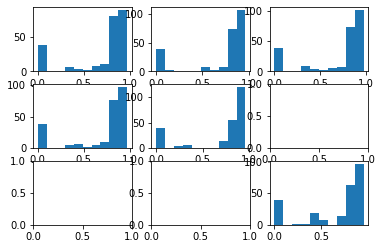

In [28]:
fig, axs = plt.subplots(3,3)
axs = axs.ravel()

for i, (xx, yy) in enumerate(zip(X_valid[:5], y_valid[:5])):
    ctx = featurizer.encrypt(xx)
    dd = hec.decrypt(ctx)
    
    axs[i].hist(dd[:240])
    
    
axs[-1].hist(ddl[:240])

In [11]:
ddl

array([ 6.13643712e-02,  3.16834505e-02,  5.68839646e-02, ...,
       -3.46386337e-06, -2.30578526e-07, -1.99839230e-06])

In [51]:
neural_pred = Nmodel(torch.tensor(X_train[1].reshape(1,-1)).float())

In [52]:
neural_pred

tensor([[  126.7263, -1325.0283, -6746.9990, 14051.2549, -7760.3872]],
       grad_fn=<AddBackward0>)

In [36]:
xx.max()

0.9887150053714814

In [40]:
neural_pred = Nmodel(torch.tensor(X_train[:1]).float())
#Nmodel(torch.tensor(X_valid[:1]))

In [41]:
neural_pred

tensor([[   -68.3079,  -4021.2930, -13188.7412,  24814.9121, -10345.2754]],
       grad_fn=<AddBackward0>)

여기서 만든 h_rf와 새로 만든 h_rf의 모양, 값 차이 비교

min = 0, 
max = 1인데.. 왜 -1보다 작아질까...? 

In [23]:
pred

[1354.7771911621098,
 -657.0239105224605,
 -13200.904769897461,
 19254.122360229492,
 -9825.276138305662]

In [57]:
from fase.core import commonAlgo
class HETreeEvaluator:
    """Evaluator which will perform homomorphic computation"""

    def __init__(self, 
                 b0: np.ndarray, w1, b1, w2, b2,
                 scheme,
                 parms,
                 activation_coeffs: List[float], 
                 #polynomial_evaluator: Callable,
                 
                 #relin_keys: seal.RelinKeys, galois_keys: seal.GaloisKeys, scale: float,
                 do_reduction=True):
        """Initializes with the weights used during computation.

        Args:
            b0: bias of the comparison step

        """
        self.sk = secretKey ######### 
        self.scheme = scheme
        self.algo = he.SchemeAlgo(scheme)
        self.commonAlgo = commonAlgo.CommonAlgorithms(scheme, "HEAAN")
        # scheme should hold all keys
        self.parms = parms
        
        self._activation_coeff = activation_coeffs
        self._activation_poly_degree = len(activation_coeffs) -1
        self.do_reduction = do_reduction

        # 10-degree activation -> up to 5 multiplications 
        logq_w1 = self.parms.logq - 5 * self.parms.logp
        logq_b1 = logq_w1 - self.parms.logp
        logq_b2 = logq_b1 - 5*self.parms.logp

        self.b0_ctx = self.encrypt(b0)
        #self.b0 = b0
        self.w1 = [self.to_double(w) for w in w1]
        #self.b1 = b1
        self.w2 = [self.to_double(w) for w in w2]
        #self.b2 = [w for w in b2]
        
#         self.w1_ctx = []
#         for w in w1:
#             #print('w', w)
#             temp = self.encrypt(w) 
#             scheme.modDownToAndEqual(temp, logq_w1)
#             self.w1_ctx.append(temp)
#         #self.w1_ctx = [self.encrypt(w, logq=logq_w1) for w in w1]
            
        self.b1_ctx = self.encrypt(b1, logq=logq_b1)
#         self.w2_ctx = [self.encrypt(w, logq=logq_2) for w in w2]
        self.b2_ctx = [self.encrypt(b, logq=logq_b2) for b in b2]

        self.setup_summary()      
    
    def setup_summary(self):
        print("CKKS paramters:")
        print("---------------------------")
        print(f"n = {self.parms.n}")
        print(f"logp = {self.parms.logp}")
        print(f"logq = {self.parms.logq}")
        print(f"tanh activation polynomial coeffs = {self._activation_coeff}")
        print(f"tanh activation polynomial degree = {self._activation_poly_degree}")
        
        print("\nNeural RF")
        print("---------------------------")
        print(f"")
    
    def heaan_double(self, val):
        mvec = np.zeros(self.parms.n)
        mvec[:len(val)] = np.array(val)
        return he.Double(mvec)

    def decrypt_print(self, ctx, n=20):
        res1 = self.decrypt(ctx)
        print("_____________________")
        print(res1[:n])
        print(res1.min(), res1.max())
        print("---------------------")

    def decrypt(self, enc):
        temp = self.scheme.decrypt(self.sk, enc)
        arr = np.zeros(self.parms.n, dtype=np.complex128)
        temp.__getarr__(arr)
        return arr.real
        
    def encrypt_ravel(self, val, **kwargs):
        """encrypt a list
        """
        return self.encrypt(np.array(val).ravel(), **kwargs)

    def encrypt(self, val, n=None, logp=None, logq=None):
        if n == None: n = self.parms.n
        if logp == None: logp = self.parms.logp
        if logq == None: logq = self.parms.logq
            
        ctxt = he.Ciphertext()
        vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
        vv[:len(val)] = val
        self.scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
        del vv
        return ctxt
    
    def to_double(self, val):
        n = self.parms.n
        vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
        vv[:len(val)] = val
        return he.Double(vv)
        
        
    def activation(self, ctx):
        output = he.Ciphertext()
        #output = self.commonAlgo.function_poly(ctx, 
        #               he.Double(self._activation_coeff))
        output = he.Ciphertext()
        self.algo.function_poly(output, 
                    ctx, 
                    he.Double(self._activation_coeff), 
                    self.parms.logp, 
                    self._activation_poly_degree)
        return output        
        

    def __call__(self, ctx):
        # First we add the first bias to do the comparisons
        ctx = self.compare(ctx)
        print("After compare")
        self.decrypt_print(ctx)
        ctx = self.match(ctx)
        print("after match")
        self.decrypt_print(ctx)
        outputs = self.decide(ctx)
        if self.do_reduction:
            outputs = self.reduce(outputs)

        return outputs

    def compare(self, ctx, debug=False):
        """Calculate first layer of the HNRF
        
        ctx = featurizer.encrypt(x)
        
        Assuming n, logp, logq are globally available
        
        """
        b0_ctx = self.b0_ctx
        self.scheme.addAndEqual(ctx, b0_ctx)
        # Activation
        output = self.activation(ctx)
            
        del b0_ctx, ctx

        return output
    
    def _mat_mult(self, diagonals, ctx):
        """
        Take plain vector 
        """
        scheme = self.scheme
        n = self.parms.n
        logp = self.parms.logp
        #logq = self.parms.logq

        ctx_copy = he.Ciphertext()
        ctx_copy.copy(ctx)
        
        for i, diagonal in enumerate(diagonals):
            #print("logq in mat_mult", diagonal.logq, ctx_copy.logq)
            #scheme.modDownToAndEqual(diagonal, ctx.logq)
            if i > 0: scheme.leftRotateFastAndEqual(ctx_copy, 1) # r = 1

            # Multiply with diagonal
            dd = he.Ciphertext()
            #print("diagonal")
            #self.decrypt_print(diagonal,10)
            #print("ctx")
            #self.decrypt_print(ctx_copy,10)
            #scheme.mult(dd, diagonal, ctx_copy)
            
            # Reduce the scale of diagonal
            scheme.multByConstVec(dd, ctx_copy, diagonal, logp)
            scheme.reScaleByAndEqual(dd, logp)
            #print('dd')
            #print(dd)
            
            
            if i == 0:
                mvec = np.zeros(n)
                temp = he.Ciphertext()
                scheme.encrypt(temp, he.Double(mvec), n, logp, ctx_copy.logq - logp)
                ##scheme.modDownToAndEqual(temp, ctx_copy.logq)
                #print("temp",i)
                #print(temp)
                #self.decrypt_print(temp,10)
            
            # match scale 
            scheme.addAndEqual(temp, dd)

            #print("temp",i)
            #self.decrypt_print(temp,10)
            
            del dd
        del ctx_copy
        return temp


    def match(self, ctx):
        """Applies matching homomorphically.

        First it does the matrix multiplication with diagonals, then activate it.
        """
        output = self._mat_mult(self.w1, ctx)

        #print(f"MATCH:: 'output.logq', {output.logq} == {self.b1_ctx.logq}?")
        self.scheme.addAndEqual(output, self.b1_ctx)
        
        output = self.activation(output)
        return output

    def decide(self, ctx):
        """Applies the decisions homomorphically.

        For each class, multiply the ciphertext with the corresponding weight of that class and
        add the bias afterwards.
        """
        # ww와 bb도 미리 modDowntoAndEqual 가능 
        outputs = []

        for ww, bb in zip(self.w2, self.b2_ctx):
            output = he.Ciphertext()
            
            # Multiply weights            
            #self.scheme.mult(output, ww, ctx)
            
            scheme.multByConstVec(output, ctx, ww, ctx.logp)
            #print("ctx", ctx)
            #print("bb", bb)
            self.scheme.reScaleByAndEqual(output, ctx.logp)
            
            # Add bias
            self.scheme.addAndEqual(output, bb)
            
            outputs.append(output)
        return outputs

    def _sum_reduce(self, ctx, logn, scheme):
        """
        return sum of a Ciphertext (repeated nslot times)
        
        example
        -------
        sum_reduct([1,2,3,4,5])
        >> [15,15,15,15,15]
        """
        output = he.Ciphertext()
        
        for i in range(logn):
            
            if i == 0:
                temp = he.Ciphertext(ctx.logp, ctx.logq, ctx.n)
                #print(i, ctx, temp)
                #print("reduce: ctx before rot")
                # self.decrypt_print(ctx,10)
                
                scheme.leftRotateFast(temp, ctx, 2**i)
                #print(i, ctx, temp)
                #print("reduce: before add")
                # self.decrypt_print(temp,10)
                scheme.add(output, ctx, temp)
                #print("reduce: after add")
                # self.decrypt_print(output,10)
            else:
                scheme.leftRotateFast(temp, output, 2**i)
                #print(i, output, temp)
                #print("reduce: before add")
                # self.decrypt_print(output,10)
                # self.decrypt_print(temp,10)
                scheme.addAndEqual(output, temp)
                #print("reduce: after add")
                # self.decrypt_print(output,10)
        return output


    def reduce(self, outputs):
        logp = self.parms.logp
        scheme = self.scheme

        for i, output in enumerate(outputs):
            # print("reduce before",)
            # self.decrypt_print(output,10)
            #output = sum_reduce(output, self.parms.logn, self.scheme)
            output = self._sum_reduce(output, self.parms.logn, self.scheme)

            # print("reduce after",)
            # self.decrypt_print(output,10)

            mask = np.zeros(self.parms.n)
            mask[0] = 1
            mask_hedb = he.ComplexDouble(mask)
            if i == 0:
                scores = he.Ciphertext()
                scheme.multByConstVec(scores, output, mask_hedb, logp)
                # print("reduce score",i)
                # self.decrypt_print(scores,10)
                # print("before rescale", scores)
                scheme.reScaleByAndEqual(scores, logp)
                # print("before rescale", scores)
            else:
                temp = he.Ciphertext()
                scheme.multByConstVec(temp, output, mask_hedb, logp)
                # print("reduce score",i)
                # self.decrypt_print(scores,10)
                # print("before rescale", scores)
                scheme.reScaleByAndEqual(temp, logp)
                # print("after rescale", scores)
                scheme.rightRotateFastAndEqual(temp, i)
                scheme.addAndEqual(scores, temp)

        return scores


    @classmethod
    def from_model(cls, model,
                   scheme,
                   parms,
                   activation_coeffs: List[float],
                   do_reduction=False):
        """Creates an Homomorphic Tree Evaluator from a model, i.e a neural tree or
        a neural random forest. """
        b0, w1, b1, w2, b2 = model.return_weights()

        return cls(b0, w1, b1, w2, b2, scheme, parms, activation_coeffs, do_reduction)
